In [1]:
import pyomo.environ as pyo
import numpy as np
import networkx as nx
import pandas as pd
import numpy as np

import igraph as ig
from igraph import Graph
from tqdm import tqdm

from itertools import combinations

import matplotlib.pyplot as plt

from scipy import stats

from copy import deepcopy
import random

import seaborn as sns

In [2]:
def graph_distances_dict(graph, weight='weight'):
    """
    Вычисляет матрицу кратчайших путей и возвращает результат в виде словаря с именами вершин.
    
    :param graph: Граф igraph.
    :param weight: Название атрибута, использующегося как вес.
    :return: Словарь, где ключи — имена вершин, значения — словари расстояний до других вершин.
    """
    # Получаем имена вершин
    vertex_names = graph.vs["name"] if "name" in graph.vs.attributes() else list(range(graph.vcount()))
    
    # Вычисляем матрицу расстояний
    distances = graph.distances(weights=weight)
    
    # Преобразуем в словарь
    distances_dict = {
        vertex_names[i]: {
            vertex_names[j]: distances[i][j]
            for j in range(len(vertex_names))
        }
        for i in range(len(vertex_names))
    }
    
    return distances_dict


def protected_distance(graph, weight='weight'):
    # Проверяем, является ли граф двусвязным
    biconnected = graph.is_biconnected()

    # Предвычисляем все кратчайшие пути с использованием алгоритма Дейкстры для оригинального графа
    all_shortest_paths = graph_distances_dict(graph, weight=weight)
    
    # Создаем копию для хранения результатов
    res_dict = all_shortest_paths

    # Перебор всех рёбер
    for edge_id in tqdm(range(graph.ecount())):

        # Используем deepcopy для копирования графа
        temp_graph = deepcopy(graph)
        temp_graph.delete_edges(edge_id)

        # Убедимся, что все рёбра в temp_graph имеют числовой вес
        for edge in temp_graph.es:
            if not isinstance(edge['weight'], (int, float)) or pd.isnull(edge['weight']):
                edge['weight'] = 1

        # Пересчитываем все кратчайшие пути после удаления рёбра
        cur_shortest_paths = graph_distances_dict(temp_graph, weight=weight)

        # Сравниваем и обновляем результаты
        for node_1 in graph.vs:
            u = node_1['name']
            for node_2 in graph.vs:
                v = node_2['name']
                if cur_shortest_paths[u][v] > res_dict[u][v]:
                    if cur_shortest_paths[u][v] == float('inf'):
                        res_dict[u][v] == 10^6
                    else:
                        res_dict[u][v] = cur_shortest_paths[u][v]

    return pd.DataFrame(res_dict), biconnected

In [3]:
def prune_leaf_nodes(graph):
    # Создаем копию графа, чтобы не изменять оригинальный граф
    G = graph.copy()

    # Пока есть вершины степени 1
    while True:
        # Находим все вершины степени 1
        leaf_nodes = [node for node in G.nodes() if G.degree(node) == 1]

        # Если нет вершин степени 1, выходим из цикла
        if len(leaf_nodes) == 0:
            break

        # Удаляем найденные вершины степени 1
        G.remove_nodes_from(leaf_nodes)

    return G

def protected_distance_dict(graph, weight='weight', inf_par=10**5):
    # Проверяем, является ли граф двусвязным
    biconnected = graph.is_biconnected()

    # Предвычисляем все кратчайшие пути с использованием алгоритма Дейкстры для оригинального графа
    all_shortest_paths = graph.distances(weights=weight)
    
    # Создаем копию для хранения результатов
    res_dict = [list(row) for row in all_shortest_paths]

    # Перебор всех рёбер
    for edge_id in tqdm(range(graph.ecount())):
        # Используем deepcopy для копирования графа
        temp_graph = deepcopy(graph)
        temp_graph.delete_edges(edge_id)

        # Убедимся, что все рёбра в temp_graph имеют числовой вес
        for edge in temp_graph.es:
            if not isinstance(edge['weight'], (int, float)) or pd.isnull(edge['weight']):
                edge['weight'] = 1

        # Пересчитываем все кратчайшие пути после удаления рёбра
        cur_shortest_paths = temp_graph.distances(weights=weight)

        # Сравниваем и обновляем результаты
        for u in range(graph.vcount()):
            for v in range(graph.vcount()):
                if cur_shortest_paths[u][v] == float('inf'):
                    cur_shortest_paths[u][v] = inf_par + all_shortest_paths[u][v]  # Или любое другое большое число
                if cur_shortest_paths[u][v] > res_dict[u][v]:
                    res_dict[u][v] = cur_shortest_paths[u][v]
                    
    # Преобразуем res_dict в словарь с использованием имен вершин
    distance_dict = {}
    for u in range(graph.vcount()):
        for v in range(graph.vcount()):
            vertex_u = graph.vs[u]["name"]
            vertex_v = graph.vs[v]["name"]
            distance_dict[(vertex_u, vertex_v)] = res_dict[u][v]

    return distance_dict, biconnected

In [4]:
# Загружаем данные и добавляем веса
TT_edges = pd.read_csv('Tata_upd.csv')

# Предполагается, что 'source' и 'target' существуют в TT_edges и являются именами узлов
# Добавляем столбец 'weight' в DataFrame
TT_edges['weight'] = 1

# Копируем DataFrame и создаем пары
df = TT_edges.copy()
df['pair'] = df.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)

# Удаляем дубликаты
df = df.drop_duplicates(subset='pair')

# Преобразуем обратно в DataFrame с колонками 'source', 'target' и другими атрибутами
unique_pairs_df = df.drop(columns=['pair']).reset_index(drop=True)
TT_edges = unique_pairs_df

# Создание графа через igraph с учетом атрибута 'weight'
TT_ig = ig.Graph.TupleList(TT_edges.itertuples(index=False), directed=False, edge_attrs=list(TT_edges.columns[2:]))

# Проверка и установка весов для всех рёбер
for edge in TT_ig.es:
    if not isinstance(edge['weight'], (int, float)) or pd.isnull(edge['weight']):
        edge['weight'] = 1
        
        
TT = nx.from_pandas_edgelist(TT_edges)
for (a,b) in TT.edges():
    TT[a][b]['weight'] = 1

In [5]:
#pruned_graph = prune_leaf_nodes(TT)

# Создаем DataFrame с рёбрами после очистки
#pruned_edges_df = pd.DataFrame(list(pruned_graph.edges()), columns=['source', 'target'])

# Сохраняем очищенные рёбра в CSV файл
#pruned_edges_df.to_csv('Tata_upd.csv', index=False)

In [6]:
protected_data = pd.DataFrame(protected_distance(TT_ig, weight='weight')[0])
protected_data.replace(np.inf, 10**9, inplace=True)
resistance_data = pd.DataFrame(nx.resistance_distance(TT, weight='weight'))
distance_data = pd.DataFrame(dict(nx.all_pairs_shortest_path_length(TT)))
distance_data = distance_data.sort_index(axis=0).sort_index(axis=1)

prot_dict, bi = protected_distance_dict(TT_ig, weight='weight')

100%|██████████| 177/177 [00:00<00:00, 215.84it/s]


In [7]:
def optimize_facility_location(input_data, p, glpk_path):
    """
    Оптимизация размещения объектов с использованием Pyomo.
    
    :param input_data: DataFrame с матрицей расстояний или затрат.
    :param p: Количество объектов для размещения.
    :param glpk_path: Путь к исполняемому файлу glpsol.
    :return: Словарь результатов с выбранными объектами и клиентами.
    """
    # Подготовка данных
    m = len(input_data.index)  # Количество клиентов
    n = len(input_data.columns)  # Количество возможных мест для размещения
    c = input_data.to_numpy()

    # Модель Pyomo
    model = pyo.ConcreteModel()
    model.M = pyo.Set(initialize=list(input_data.index))  # Клиенты
    model.N = pyo.Set(initialize=list(input_data.columns))  # Возможные места для размещения

    # Параметры (матрица затрат)
    model.c = pyo.Param(
        model.M, 
        model.N, 
        initialize=lambda model, i, j: c[
            list(input_data.index).index(i)][list(input_data.columns).index(j)], 
        within=pyo.NonNegativeReals
    )

    # Переменные
    model.x = pyo.Var(model.M, model.N, within=pyo.Binary)
    model.y = pyo.Var(model.N, within=pyo.Binary)

    # Целевая функция
    def obj_rule(model):
        return sum(model.c[i, j] * model.x[i, j] for i in model.M for j in model.N)
    model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # Ограничения
    def single_assignment_rule(model, i):
        return sum(model.x[i, j] for j in model.N) == 1
    model.single_assignment = pyo.Constraint(model.M, rule=single_assignment_rule)

    def facility_open_rule(model, i, j):
        return model.x[i, j] <= model.y[j]
    model.facility_open = pyo.Constraint(model.M, model.N, rule=facility_open_rule)

    model.facility_count = pyo.Constraint(expr=sum(model.y[j] for j in model.N) == p)

    # Решение задачи
    solver = pyo.SolverFactory('glpk', executable=glpk_path)
    result = solver.solve(model, tee=True)

    # Формирование словаря результатов
    result_dict = {}
    for j in model.N:
        if pyo.value(model.y[j]) > 0.5:
            result_dict[j] = []
            for i in model.M:
                if pyo.value(model.x[i, j]) > 0.5:
                    result_dict[j].append(i)

    return {
        "result_dict": result_dict,
        "selected_facilities": list(result_dict.keys())
    }

def get_max_from_result_dict(result_dict, prot_dict):
    """
    Возвращает максимальное значение из списка, сформированного на основе result_dict и prot_dict.

    :param result_dict: Словарь с ключами (места) и значениями (список клиентов).
    :param prot_dict: Словарь с возможными парами (ключами) и значениями.
    :return: Максимальное значение из сформированного списка или None, если список пуст.
    """
    result_list = []
    
    for i in result_dict.keys():
        for u in result_dict[i]:
            try:
                # Попытка взять значение из prot_dict[i][u]
                value = prot_dict[(i, u)]
            except KeyError:
                try:
                    # Если не получилось, пытаемся взять из prot_dict[u][i]
                    value = prot_dict[(u, i)]
                except KeyError:
                    # Если ни один ключ не найден, пропускаем
                    value = None
            if value is not None:
                result_list.append(int(value))
    
    # Возвращаем максимум или None, если список пуст
    return max(result_list) if result_list else None


def optimize_and_compute_max(input_data, p_range, glpk_path, prot_dict):
    """
    Вызывает optimize_facility_location для каждого p из p_range, затем вычисляет максимум через get_max_from_result_dict.
    
    :param input_data: DataFrame с матрицей расстояний или затрат.
    :param p_range: Итерабельный объект с диапазоном значений p.
    :param glpk_path: Путь к исполняемому файлу glpsol.
    :param prot_dict: Словарь с парами (ключами) и их значениями для расчёта максимумов.
    :return: Список словарей с результатами для каждого p.
    """
    results = []
    
    for p in p_range:
        # Шаг 1: Оптимизация для текущего значения p
        result = optimize_facility_location(input_data, p, glpk_path)
        result_dict = result["result_dict"]
        
        # Шаг 2: Вычисление максимального значения
        max_value = get_max_from_result_dict(result_dict, prot_dict)
        
        # Шаг 3: Сохранение результата
        results.append({
            "p": p,
            "max_value": max_value
        })
    
    return results

In [8]:
# glpk_path = 'C:/Users/uvan6/Downloads/glpk-4.65/w64/glpsol.exe'
glpk_path = '/usr/local/bin/glpsol'

In [9]:
results_geodesic = optimize_and_compute_max(distance_data, [i for i in range(1,10)], glpk_path, prot_dict)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/tmp/tmpbkv3si7d.glpk.raw --wglp /var/tmp/tmpa1u_k9fv.glpk.glp
 --cpxlp /var/tmp/tmp4vpmciya.pyomo.lp
Reading problem data from '/var/tmp/tmp4vpmciya.pyomo.lp'...
/var/tmp/tmp4vpmciya.pyomo.lp:148525: warning: lower bound of variable 'x18363' redefined
/var/tmp/tmp4vpmciya.pyomo.lp:148525: warning: upper bound of variable 'x18363' redefined
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
167157 lines were read
Writing problem data to '/var/tmp/tmpa1u_k9fv.glpk.glp'...
129885 lines were written
GLPK Integer Optimizer 5.0
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Preprocessing...
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basi

In [10]:
results_resistance = optimize_and_compute_max(resistance_data, [i for i in range(1,10)], glpk_path, prot_dict)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/tmp/tmp8kt5b07k.glpk.raw --wglp /var/tmp/tmpby67ck4f.glpk.glp
 --cpxlp /var/tmp/tmp7_sd3k7c.pyomo.lp
Reading problem data from '/var/tmp/tmp7_sd3k7c.pyomo.lp'...
/var/tmp/tmp7_sd3k7c.pyomo.lp:148525: warning: lower bound of variable 'x18363' redefined
/var/tmp/tmp7_sd3k7c.pyomo.lp:148525: warning: upper bound of variable 'x18363' redefined
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
167157 lines were read
Writing problem data to '/var/tmp/tmpby67ck4f.glpk.glp'...
129885 lines were written
GLPK Integer Optimizer 5.0
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Preprocessing...
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basi

In [11]:
results_guf = optimize_and_compute_max(protected_data, [i for i in range(1,10)], glpk_path, prot_dict)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/tmp/tmpqh2q78ed.glpk.raw --wglp /var/tmp/tmp4aszf3tl.glpk.glp
 --cpxlp /var/tmp/tmp51kq2qn8.pyomo.lp
Reading problem data from '/var/tmp/tmp51kq2qn8.pyomo.lp'...
/var/tmp/tmp51kq2qn8.pyomo.lp:148525: warning: lower bound of variable 'x18363' redefined
/var/tmp/tmp51kq2qn8.pyomo.lp:148525: warning: upper bound of variable 'x18363' redefined
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
167157 lines were read
Writing problem data to '/var/tmp/tmp4aszf3tl.glpk.glp'...
129885 lines were written
GLPK Integer Optimizer 5.0
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Preprocessing...
18633 rows, 18632 columns, 55624 non-zeros
18632 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basi

In [12]:
results_guf

[{'p': 1, 'max_value': 19},
 {'p': 2, 'max_value': 14},
 {'p': 3, 'max_value': 13},
 {'p': 4, 'max_value': 13},
 {'p': 5, 'max_value': 12},
 {'p': 6, 'max_value': 12},
 {'p': 7, 'max_value': 12},
 {'p': 8, 'max_value': 10},
 {'p': 9, 'max_value': 10}]

In [13]:
def plot_comparison(results_list, labels):
    """
    Строит график для сравнения массивов max_value из нескольких результатов optimize_and_compute_max.
    
    :param results_list: Список результатов (массивов словарей) от optimize_and_compute_max.
    :param labels: Список подписей для каждого набора данных.
    """
    if len(results_list) != len(labels):
        raise ValueError("Количество результатов должно совпадать с количеством подписей.")
    
    plt.figure(figsize=(5, 3))
    
    for results, label in zip(results_list, labels):
        # Извлекаем значения p и max_value
        p_values = [result['p'] for result in results]
        max_values = [result['max_value'] for result in results]
        
        # Построение графика
        plt.plot(p_values, max_values, marker='o', label=label)
    
    # Настройка графика
    plt.xlabel("Number of facilities")
    plt.ylabel("Worst distance GUF")
    plt.legend()
    plt.grid(True)
    plt.show()

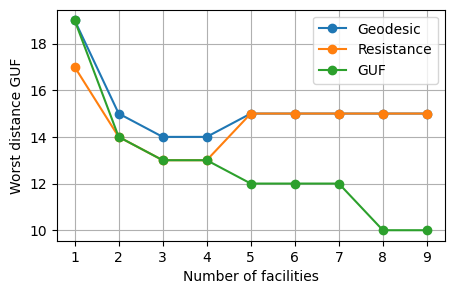

In [14]:
labels = ["Geodesic", "Resistance", "GUF"]

plot_comparison([results_geodesic,results_resistance,results_guf], labels)